<a href="https://colab.research.google.com/github/reagan13/gpt2-distilbert-thesis-files/blob/main/notebook/Baseline_version_1_freeze_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multitask Learning with GPT2

## Import Libraries

In [1]:
# Cell 1: Imports and Setup
import json
from typing import List, Dict, Optional
import time
from collections import Counter, defaultdict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Config, GPT2Model, GPT2TokenizerFast
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os
# Import the datetime module
from datetime import datetime
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/thesis/Baseline_freeze_v1"
os.makedirs(output_dir, exist_ok=True)
log_file = os.path.join(output_dir, "training_log.txt")

def log_to_file(message: str):
    with open(log_file, 'a') as f:
        f.write(f"{message}\n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_to_file(f"Using device: {device}")

def check_device(tensor_or_model, name: str):
    if isinstance(tensor_or_model, torch.nn.Module):
        device_name = next(tensor_or_model.parameters()).device
    else:
        device_name = tensor_or_model.device
    log_to_file(f"{name} is on: {device_name}")
    print(f"{name} is on: {device_name}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Daset Loading Functions

In [2]:
# Cell 2: Data Loading and Label Detection
def load_dataset(json_file: str) -> List[Dict]:
    log_to_file(f"Loading dataset from {json_file}...")
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        log_to_file(f"Loaded {len(data)} samples from {json_file}")
        return data
    except Exception as e:
        log_to_file(f"Error loading {json_file}: {e}")
        return []

def detect_labels(data: List[Dict]) -> Dict[str, Dict]:
    log_to_file("Detecting labels...")
    if not data:
        log_to_file("Warning: Empty dataset")
        return {"category_encoder": {}, "intent_encoder": {}, "ner_label_encoder": {"O": 0}}

    unique_categories = set()
    unique_intents = set()
    unique_ner_labels = set(["O"])

    for i, sample in enumerate(data):
        unique_categories.add(sample["category"])
        unique_intents.add(sample["intent"])
        for label in sample["ner_labels_only"]:
            label_type = label["label"]
            unique_ner_labels.add(f"B-{label_type}")
            unique_ner_labels.add(f"I-{label_type}")

    category_encoder = {cat: idx for idx, cat in enumerate(sorted(unique_categories))}
    intent_encoder = {intent: idx for idx, intent in enumerate(sorted(unique_intents))}
    ner_label_encoder = {ner: idx for idx, ner in enumerate(sorted(unique_ner_labels))}

    log_to_file(f"Label detection summary: Categories={len(category_encoder)}, Intents={len(intent_encoder)}, NER tags={len(ner_label_encoder)}")
    return {"category_encoder": category_encoder, "intent_encoder": intent_encoder, "ner_label_encoder": ner_label_encoder}


## Tokenization and NER Alignment

In [3]:
# Cell 3: Tokenization and NER Alignment
def tokenize_text_gpt2(text: str, gpt2_tokenizer, max_length: int) -> Dict[str, torch.Tensor]:
    """Tokenize text with GPT-2 tokenizer."""
    # print(f"Tokenizing text: {text[:50]}...")
    gpt2_inputs = gpt2_tokenizer(
        text, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return {
        "gpt2_input_ids": gpt2_inputs["input_ids"].squeeze(0),
        "gpt2_attention_mask": gpt2_inputs["attention_mask"].squeeze(0)
    }

def align_ner_labels(text: str, ner_labels: List[Dict], tokenizer, ner_label_encoder: Dict, max_length: int, sample_idx: int = -1) -> torch.Tensor:
    global print_counter
    if 'print_counter' not in globals():
        print_counter = 0

    should_log = print_counter < 2 and sample_idx >= 0
    if should_log:
        log_to_file(f"Aligning NER labels for text: {text[:50]}...")
        log_to_file(f"NER Labels: {ner_labels}")
    print_counter += 1 if sample_idx >= 0 else 0

    sorted_labels = sorted(ner_labels, key=lambda x: len(x["text"]), reverse=True) if ner_labels else []
    encoding = tokenizer(
        text, max_length=max_length, padding="max_length", truncation=True, return_offsets_mapping=True, return_tensors="pt"
    )
    token_to_char_map = encoding["offset_mapping"][0].tolist()
    ner_aligned = [ner_label_encoder["O"]] * max_length

    text_lower = text.lower()
    found_count = 0
    not_found_count = 0

    for label in sorted_labels:
        if "text" not in label or "label" not in label:
            if should_log:
                log_to_file(f"Warning: Skipping invalid NER entry {label}")
            continue
        label_text, label_type = label["text"], label["label"]
        label_text_lower = label_text.lower()
        start_pos = 0
        found_at_least_once = False
        while True:
            label_start = text_lower.find(label_text_lower, start_pos)
            if label_start == -1:
                if not found_at_least_once:
                    not_found_count += 1
                break
            label_end = label_start + len(label_text_lower)
            found_at_least_once = True
            found_count += 1
            start_pos = label_end
            first_token = True
            tokens_tagged = False
            for i, (start, end) in enumerate(token_to_char_map):
                if start == 0 and end == 0:
                    continue
                if start < label_end and end > label_start and end > start:
                    prefix = "B-" if first_token else "I-"
                    first_token = False
                    ner_aligned[i] = ner_label_encoder.get(f"{prefix}{label_type}", ner_label_encoder["O"])
                    tokens_tagged = True
            if not tokens_tagged and should_log:
                log_to_file(f"Warning: No tokens aligned for '{label_text}' ({label_type}) at {label_start}-{label_end}")

    if should_log:
        tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0].tolist())
        seq_len = encoding["attention_mask"][0].sum().item()
        log_to_file("Debug Aligned Labels:")
        log_to_file("Token | Aligned Label")
        for token, label_idx in zip(tokens[:seq_len], ner_aligned[:seq_len]):
            label = list(ner_label_encoder.keys())[list(ner_label_encoder.values()).index(label_idx)]
            log_to_file(f"{token:<15} | {label}")
        log_to_file(f"Alignment Summary: {found_count} entities found, {not_found_count} entities not found")

    return torch.tensor(ner_aligned, dtype=torch.long)

## NER ALINGNMENT OPTIONAL CODE

In [ ]:
# def align_ner_labels(text: str, ner_labels: List[Dict], tokenizer, ner_label_encoder: Dict, max_length: int) -> torch.Tensor:
#     """Align NER labels with tokenized input."""
#     print(f"Aligning NER labels for text: {text[:50]}...")
#     print(f"NER Labels: {ner_labels}")
#     sorted_labels = sorted(ner_labels, key=lambda x: len(x["text"]), reverse=True) if ner_labels else []
#     encoding = tokenizer(
#         text, max_length=max_length, padding="max_length", truncation=True, return_offsets_mapping=True, return_tensors="pt"
#     )
#     token_to_char_map = encoding["offset_mapping"][0].tolist()
#     ner_aligned = [ner_label_encoder["O"]] * max_length

#     text_lower = text.lower()

#     for label in sorted_labels:
#         if "text" not in label or "label" not in label:
#             print(f"Warning: Skipping invalid NER entry {label}")
#             continue
#         label_text, label_type = label["text"], label["label"]
#         label_text_lower = label_text.lower()
#         start_pos = 0
#         found_at_least_once = False
#         while True:
#             label_start = text_lower.find(label_text_lower, start_pos)
#             if label_start == -1:
#                 if not found_at_least_once:
#                     print(f"Debug: Could not find '{label_text_lower}' in full text '{text_lower}'")
#                 break
#             label_end = label_start + len(label_text_lower)
#             print(f"Found '{label_text}' ({label_type}) at {label_start}-{label_end}")
#             found_at_least_once = True
#             start_pos = label_end
#             first_token = True
#             tokens_tagged = False
#             for i, (start, end) in enumerate(token_to_char_map):
#                 if start == 0 and end == 0:  # Skip padding
#                     continue
#                 if start < label_end and end > label_start and end > start:
#                     prefix = "B-" if first_token else "I-"
#                     first_token = False
#                     ner_aligned[i] = ner_label_encoder.get(f"{prefix}{label_type}", ner_label_encoder["O"])
#                     tokens_tagged = True
#                     token_id = encoding['input_ids'][0][i].item()
#                     token_str = tokenizer.convert_ids_to_tokens(token_id)
#                     print(f"Tagged token {i} ({token_str}) as {prefix}{label_type}")
#             if not tokens_tagged:
#                 print(f"Warning: No tokens aligned for '{label_text}' ({label_type}) at {label_start}-{label_end}")

#     tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0].tolist())
#     seq_len = encoding["attention_mask"][0].sum().item()
#     print("Debug Aligned Labels:")
#     print("Token | Aligned Label")
#     for token, label_idx in zip(tokens[:seq_len], ner_aligned[:seq_len]):
#         label = list(ner_label_encoder.keys())[list(ner_label_encoder.values()).index(label_idx)]
#         print(f"{token:<15} | {label}")
#     return torch.tensor(ner_aligned, dtype=torch.long)

## Dataset and Dataloader

In [4]:
class MultiTaskDataset(Dataset):
    def __init__(self, data: List[Dict], gpt2_tokenizer, label_encoders, max_length: int):
        self.data = data
        self.gpt2_tokenizer = gpt2_tokenizer
        self.label_encoders = label_encoders
        self.max_length = max_length
        log_to_file(f"Initialized dataset with {len(data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        text = sample["instruction"]
        gpt2_inputs = tokenize_text_gpt2(text, self.gpt2_tokenizer, self.max_length)
        ner_labels = align_ner_labels(text, sample["ner_labels_only"], self.gpt2_tokenizer,
                                      self.label_encoders["ner_label_encoder"], self.max_length, sample_idx=idx)
        return {
            "input_ids": gpt2_inputs["gpt2_input_ids"],
            "attention_mask": gpt2_inputs["gpt2_attention_mask"],
            "category_labels": torch.tensor(self.label_encoders["category_encoder"][sample["category"]], dtype=torch.long),
            "intent_labels": torch.tensor(self.label_encoders["intent_encoder"][sample["intent"]], dtype=torch.long),
            "ner_labels": ner_labels
        }

def get_dataloaders(train_data, val_data, test_data, gpt2_tokenizer, label_encoders, batch_size, num_workers, max_length):
    """Create DataLoaders."""
    pin_memory = device.type == "cuda"
    log_to_file("Creating DataLoaders...")
    train_dataset = MultiTaskDataset(train_data, gpt2_tokenizer, label_encoders, max_length)
    val_dataset = MultiTaskDataset(val_data, gpt2_tokenizer, label_encoders, max_length)
    test_dataset = MultiTaskDataset(test_data, gpt2_tokenizer, label_encoders, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    log_to_file(f"DataLoaders created: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")
    return train_loader, val_loader, test_loader


## Model Architecture

In [5]:
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2Model
from typing import Dict, Optional

class BaselineGPT2MultiTask(nn.Module):
    def __init__(self, num_intents: int, num_categories: int, num_ner_labels: int,
                 dropout_rate: float, loss_weights: Dict[str, float],
                 ner_class_weights: torch.Tensor, category_class_weights: torch.Tensor,
                 intent_class_weights: torch.Tensor):
        super().__init__()
        log_to_file("Initializing model...")
        self.config = GPT2Config.from_pretrained('gpt2')
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        hidden_size = self.config.n_embd

        # Freeze all GPT-2 parameters
        for param in self.gpt2.parameters():
            param.requires_grad = False
        log_to_file("All GPT-2 layers remain frozen")

        # # Unfreeze the first two layers
        # for i, layer in enumerate(self.gpt2.children()):
        #     if i < 2:  # Unfreeze only the first two layers
        #         for param in layer.parameters():
        #             param.requires_grad = True
        #     else:  # Freeze the rest of the layers
        #         for param in layer.parameters():
        #             param.requires_grad = False
        # print("The first two GPT-2 layers have been unfrozen")

        # Task-specific heads
        self.intent_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.Tanh(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_intents)
        )
        self.category_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.Tanh(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_categories)
        )
        self.ner_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.Tanh(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_ner_labels)
        )

        # Loss functions with class weights
        self.intent_loss_fn = nn.CrossEntropyLoss(weight=intent_class_weights)
        self.category_loss_fn = nn.CrossEntropyLoss(weight=category_class_weights)
        self.ner_loss_fn = nn.CrossEntropyLoss(weight=ner_class_weights)
        self.loss_weights = loss_weights


        log_to_file(f"Model initialized with loss weights: {self.loss_weights}")
        if intent_class_weights is not None:
            log_to_file(f"Intent class weights applied: {intent_class_weights[:5]}...")
        if category_class_weights is not None:
            log_to_file(f"Category class weights applied: {category_class_weights[:5]}...")
        if ner_class_weights is not None:
            log_to_file(f"NER class weights applied: {ner_class_weights[:5]}...")

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor,
                intent_labels: Optional[torch.Tensor] = None,
                category_labels: Optional[torch.Tensor] = None,
                ner_labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        # Mean pooling for intent and category
        masked_features = sequence_output * attention_mask.unsqueeze(-1)
        sequence_repr = masked_features.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

        intent_logits = self.intent_head(sequence_repr)
        category_logits = self.category_head(sequence_repr)
        ner_logits = self.ner_head(sequence_output)

        output_dict = {
            'intent_logits': intent_logits,
            'category_logits': category_logits,
            'ner_logits': ner_logits
        }

        if all(label is not None for label in [intent_labels, category_labels, ner_labels]):
            intent_loss = self.intent_loss_fn(intent_logits, intent_labels)
            category_loss = self.category_loss_fn(category_logits, category_labels)
            active_loss = attention_mask.view(-1) == 1
            active_logits = ner_logits.view(-1, ner_logits.size(-1))[active_loss]
            active_labels = ner_labels.view(-1)[active_loss]
            ner_loss = self.ner_loss_fn(active_logits, active_labels)

            total_loss = (self.loss_weights['intent'] * intent_loss +
                          self.loss_weights['category'] * category_loss +
                          self.loss_weights['ner'] * ner_loss)

            output_dict.update({
                'loss': total_loss,
                'intent_loss': intent_loss,
                'category_loss': category_loss,
                'ner_loss': ner_loss
            })
        return output_dict

## Training Loop

In [6]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

# Cell 6: Training Function
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    model.to(device)
    check_device(model, "Model")
    history = {"train_loss": [], "val_loss": [], "train_intent_f1": [], "val_intent_f1": [],
               "train_category_f1": [], "val_category_f1": [], "train_ner_f1": [], "val_ner_f1": []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_train_intent_preds, all_train_intent_labels = [], []
        all_train_category_preds, all_train_category_labels = [], []
        all_train_ner_preds, all_train_ner_labels = [], []

        log_to_file(f"Starting Epoch {epoch+1}/{num_epochs} [Training]")
        for i, batch in enumerate(tqdm(train_loader, desc="Training")):
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items()}
            if i == 0:
                check_device(inputs["input_ids"], "Input IDs")
            outputs = model(**inputs)
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            intent_preds = torch.argmax(outputs["intent_logits"], dim=-1).cpu().numpy()
            category_preds = torch.argmax(outputs["category_logits"], dim=-1).cpu().numpy()
            ner_preds = torch.argmax(outputs["ner_logits"], dim=-1).cpu().numpy()
            all_train_intent_preds.extend(intent_preds)
            all_train_intent_labels.extend(batch["intent_labels"].cpu().numpy())
            all_train_category_preds.extend(category_preds)
            all_train_category_labels.extend(batch["category_labels"].cpu().numpy())
            all_train_ner_preds.extend(ner_preds.flatten())
            all_train_ner_labels.extend(batch["ner_labels"].cpu().numpy().flatten())

        train_intent_f1 = precision_recall_fscore_support(all_train_intent_labels, all_train_intent_preds, average="macro", zero_division=0)[2]
        train_category_f1 = precision_recall_fscore_support(all_train_category_labels, all_train_category_preds, average="macro", zero_division=0)[2]
        train_ner_f1 = precision_recall_fscore_support(all_train_ner_labels, all_train_ner_preds, average="macro", zero_division=0)[2]
        history["train_loss"].append(total_loss / len(train_loader))
        history["train_intent_f1"].append(train_intent_f1)
        history["train_category_f1"].append(train_category_f1)
        history["train_ner_f1"].append(train_ner_f1)

        model.eval()
        val_loss = 0
        all_val_intent_preds, all_val_intent_labels = [], []
        all_val_category_preds, all_val_category_labels = [], []
        all_val_ner_preds, all_val_ner_labels = [], []

        log_to_file(f"Epoch {epoch+1}/{num_epochs} [Validation]")
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)
                val_loss += outputs["loss"].item()
                intent_preds = torch.argmax(outputs["intent_logits"], dim=-1).cpu().numpy()
                category_preds = torch.argmax(outputs["category_logits"], dim=-1).cpu().numpy()
                ner_preds = torch.argmax(outputs["ner_logits"], dim=-1).cpu().numpy()
                all_val_intent_preds.extend(intent_preds)
                all_val_intent_labels.extend(batch["intent_labels"].cpu().numpy())
                all_val_category_preds.extend(category_preds)
                all_val_category_labels.extend(batch["category_labels"].cpu().numpy())
                all_val_ner_preds.extend(ner_preds.flatten())
                all_val_ner_labels.extend(batch["ner_labels"].cpu().numpy().flatten())

        val_intent_f1 = precision_recall_fscore_support(all_val_intent_labels, all_val_intent_preds, average="macro", zero_division=0)[2]
        val_category_f1 = precision_recall_fscore_support(all_val_category_labels, all_val_category_preds, average="macro", zero_division=0)[2]
        val_ner_f1 = precision_recall_fscore_support(all_val_ner_labels, all_val_ner_preds, average="macro", zero_division=0)[2]
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_intent_f1"].append(val_intent_f1)
        history["val_category_f1"].append(val_category_f1)
        history["val_ner_f1"].append(val_ner_f1)

        log_to_file(f"Epoch {epoch+1}/{num_epochs}:")
        log_to_file(f"  Train Loss: {history['train_loss'][-1]:.4f}, Intent F1: {train_intent_f1:.4f}, Category F1: {train_category_f1:.4f}, NER F1: {train_ner_f1:.4f}")
        log_to_file(f"  Val Loss: {history['val_loss'][-1]:.4f}, Intent F1: {val_intent_f1:.4f}, Category F1: {val_category_f1:.4f}, NER F1: {val_ner_f1:.4f}")
    return history

## Evaluation

In [7]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

# Cell 7: Evaluation Function
def evaluate_model(model, test_loader, label_encoders, gpt2_tokenizer):
    model.eval()
    total_loss = 0
    all_intent_preds, all_intent_labels = [], []
    all_category_preds, all_category_labels = [], []
    all_ner_preds, all_ner_labels = [], []
    device = next(model.parameters()).device

    log_to_file("Evaluating model on test set...")
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader, desc="Evaluation")):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            total_loss += outputs["loss"].item()
            intent_preds = torch.argmax(outputs["intent_logits"], dim=-1).cpu().numpy()
            category_preds = torch.argmax(outputs["category_logits"], dim=-1).cpu().numpy()
            ner_preds = torch.argmax(outputs["ner_logits"], dim=-1).cpu().numpy()
            all_intent_preds.extend(intent_preds)
            all_intent_labels.extend(batch["intent_labels"].cpu().numpy())
            all_category_preds.extend(category_preds)
            all_category_labels.extend(batch["category_labels"].cpu().numpy())
            all_ner_preds.extend(ner_preds.flatten())
            all_ner_labels.extend(batch["ner_labels"].cpu().numpy().flatten())

            if i == 0:
                tokens = gpt2_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist())
                log_to_file("Sample Prediction (First Batch):")
                log_to_file("Token | Predicted NER | True NER")
                for token, pred, true in zip(tokens, ner_preds[0], batch["ner_labels"][0].cpu().numpy()):
                    pred_label = list(label_encoders["ner_label_encoder"].keys())[list(label_encoders["ner_label_encoder"].values()).index(pred)]
                    true_label = list(label_encoders["ner_label_encoder"].keys())[list(label_encoders["ner_label_encoder"].values()).index(true)]
                    log_to_file(f"{token:<15} | {pred_label:<15} | {true_label}")

    intent_f1 = precision_recall_fscore_support(all_intent_labels, all_intent_preds, average="macro", zero_division=0)[2]
    category_f1 = precision_recall_fscore_support(all_category_labels, all_category_preds, average="macro", zero_division=0)[2]
    ner_f1 = precision_recall_fscore_support(all_ner_labels, all_ner_preds, average="macro", zero_division=0)[2]
    avg_loss = total_loss / len(test_loader)
    log_to_file(f"Test Results:")
    log_to_file(f"  Loss: {avg_loss:.4f}")
    log_to_file(f"  Intent F1: {intent_f1:.4f}")
    log_to_file(f"  Category F1: {category_f1:.4f}")
    log_to_file(f"  NER F1: {ner_f1:.4f}")
    return {"loss": avg_loss, "intent_f1": intent_f1, "category_f1": category_f1, "ner_f1": ner_f1}

## Main Execution

### Hyperparameters

In [8]:
# Cell 8: Main Execution
train_file = "train.json"
val_file = "val.json"
test_file = "test.json"
batch_size = 16
num_epochs = 3
learning_rate = 2e-5
max_length = 128
num_workers = 2
dropout_rate = 0.2
loss_weights = {"intent": 0.2, "category": 0.2, "ner": 0.4}

### Paths and Hyperparameters

In [9]:
from google.colab import files
uploaded = files.upload()


Saving test.json to test (1).json
Saving train.json to train (1).json
Saving val.json to val (1).json


### Load Data, Label encoders and Compute Weights

In [10]:
# Load datasets
log_to_file("Loading datasets...\n")
train_data = load_dataset(train_file)
val_data = load_dataset(val_file)
test_data = load_dataset(test_file)
log_to_file(f"Dataset sizes: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
if len(train_data) == 0:
    raise ValueError("Training dataset is empty!")

# Detect labels
label_encoders = detect_labels(train_data)

# Compute NER class weights
ner_counts = Counter()
for sample in train_data:
    for label in sample["ner_labels_only"]:
        ner_counts[f"B-{label['label']}"] += 1
        ner_counts[f"I-{label['label']}"] += 1
ner_counts["O"] = sum(ner_counts.values()) * 10  # Approximate O frequency
total_ner = sum(ner_counts.values())
ner_class_weights = torch.tensor([total_ner / (len(label_encoders["ner_label_encoder"]) * ner_counts.get(tag, 1))
                                  for tag in label_encoders["ner_label_encoder"]], dtype=torch.float).to(device)

# Compute category class weights
category_counts = Counter()
for sample in train_data:
    category_counts[sample["category"]] += 1
total_category = sum(category_counts.values())
category_class_weights = torch.tensor([total_category / (len(label_encoders["category_encoder"]) * category_counts.get(cat, 1))
                                       for cat in label_encoders["category_encoder"]], dtype=torch.float).to(device)

# Compute intent class weights
intent_counts = Counter()
for sample in train_data:
    intent_counts[sample["intent"]] += 1
total_intent = sum(intent_counts.values())
intent_class_weights = torch.tensor([total_intent / (len(label_encoders["intent_encoder"]) * intent_counts.get(intent, 1))
                                     for intent in label_encoders["intent_encoder"]], dtype=torch.float).to(device)

log_to_file(f"NER class weights computed: {ner_class_weights[:5]}...")
log_to_file(f"Category class weights computed: {category_class_weights[:5]}...")
log_to_file(f"Intent class weights computed: {intent_class_weights[:5]}...")


### Initialize model and tokenizer

In [11]:
# Initialize tokenizer
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
print("Tokenizer initialized")

# Create data loaders
train_loader, val_loader, test_loader = get_dataloaders(
    train_data, val_data, test_data, gpt2_tokenizer, label_encoders, batch_size, num_workers, max_length
)

# Initialize model with all class weights
model = BaselineGPT2MultiTask(
    num_intents=len(label_encoders["intent_encoder"]),
    num_categories=len(label_encoders["category_encoder"]),
    num_ner_labels=len(label_encoders["ner_label_encoder"]),
    dropout_rate=dropout_rate,
    loss_weights=loss_weights,
    ner_class_weights=ner_class_weights,
    category_class_weights=category_class_weights,
    intent_class_weights=intent_class_weights
)

if gpt2_tokenizer.pad_token_id is not None:
    model.gpt2.resize_token_embeddings(len(gpt2_tokenizer))
model.to(device)
check_device(model, "Model before training")


# # Save training config before training
# save_training_config(training_config, save_path)

# # Train model
# print("*" * 30)
# print("Starting training...")

# start_time = time.time()
# history = train_model(model, train_loader, val_loader, num_epochs, learning_rate)
# print(f"Training completed in {(time.time() - start_time) / 60:.2f} minutes")

# print("*" * 30)

# # Evaluate model
# print("Evaluating on test set...")
# test_results = evaluate_model(model, test_loader, label_encoders, gpt2_tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer initialized


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model before training is on: cuda:0


### Start Training

In [12]:
# Save hyperparameters
hyperparameters = {
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "max_length": max_length,
    "num_workers": num_workers,
    "dropout_rate": dropout_rate,
    "loss_weights": loss_weights,
    "num_intents": len(label_encoders["intent_encoder"]),
    "num_categories": len(label_encoders["category_encoder"]),
    "num_ner_labels": len(label_encoders["ner_label_encoder"])
}
with open(os.path.join(output_dir, "hyperparameters.json"), 'w') as f:
    json.dump(hyperparameters, f, indent=4)
log_to_file("Hyperparameters saved to hyperparameters.json")

start_time = time.time()
history = train_model(model, train_loader, val_loader, num_epochs, learning_rate)
training_time = (time.time() - start_time) / 60
log_to_file(f"Training completed in {training_time:.2f} minutes")

Model is on: cuda:0


Training:   0%|          | 0/1344 [00:00<?, ?it/s]

Input IDs is on: cuda:0


Training:   0%|          | 1/1344 [00:00<09:42,  2.31it/s]

Input IDs is on: cuda:0


Training:   0%|          | 1/1344 [00:00<13:01,  1.72it/s]

Input IDs is on: cuda:0


Validation: 100%|██████████| 168/168 [00:21<00:00,  7.76it/s]


### Evaluate

### Saved Training model,result and history

In [13]:
# During training, save:
with open(os.path.join(output_dir, "label_encoders.json"), 'w') as f:
    json.dump(label_encoders, f, indent=4)


In [14]:

# Save training history
with open(os.path.join(output_dir, "training_history.json"), 'w') as f:
    json.dump(history, f, indent=4)
log_to_file("Training history saved to training_history.json")

test_results = evaluate_model(model, test_loader, label_encoders, gpt2_tokenizer)

# Save test results
with open(os.path.join(output_dir, "test_results.json"), 'w') as f:
    json.dump(test_results, f, indent=4)
log_to_file("Test results saved to test_results.json")

# Save model
model_path = os.path.join(output_dir, "baseline_model.pth")
torch.save(model.state_dict(), model_path)
log_to_file(f"Model saved to {model_path}")

Evaluation: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


# Plot

### Test Results (graph and table)

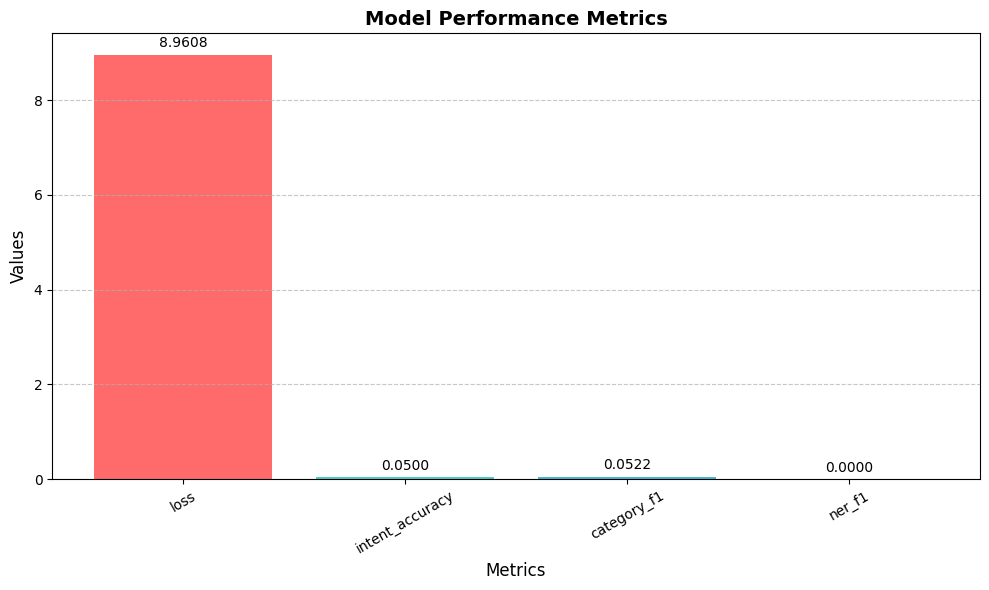

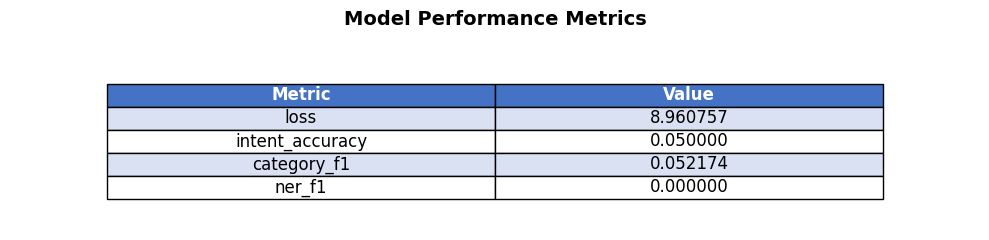

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the provided JSON
metrics = {
    "loss": 8.9607572555542,
    "intent_accuracy": 0.05,
    "category_f1": 0.05217391304347826,
    "ner_f1": 0.0
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars = ax.bar(
    range(len(metrics)),
    list(metrics.values()),
    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA62B']
)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(metrics)))
ax.set_xticklabels(list(metrics.keys()), rotation=30)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# # Save the figure
# plt.savefig('performance_metrics.png', dpi=300)

# Show the plot
plt.show()



# Table
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

# Data from the provided JSON
metrics = {
    "loss": 8.9607572555542,
    "intent_accuracy": 0.05,
    "category_f1": 0.05217391304347826,
    "ner_f1": 0.0
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 2.5))

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create table data
table_data = [
    ['Metric', 'Value'],
]

# Add each metric to the table data
for key, value in metrics.items():
    table_data.append([key, f"{value:.6f}"])

# Create the table
table = ax.table(
    cellText=table_data,
    cellLoc='center',
    loc='center',
    colWidths=[0.4, 0.4]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)  # Adjust table size

# Style header row
for i in range(len(table_data[0])):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white', fontweight='bold')

# Alternating row colors for better readability
for i in range(1, len(table_data)):
    if i % 2 == 1:
        for j in range(len(table_data[0])):
            table[(i, j)].set_facecolor('#D9E1F2')

plt.title('Model Performance Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()

# # Save the figure
# plt.savefig('performance_metrics_table.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Training Results (graph and table)

graph

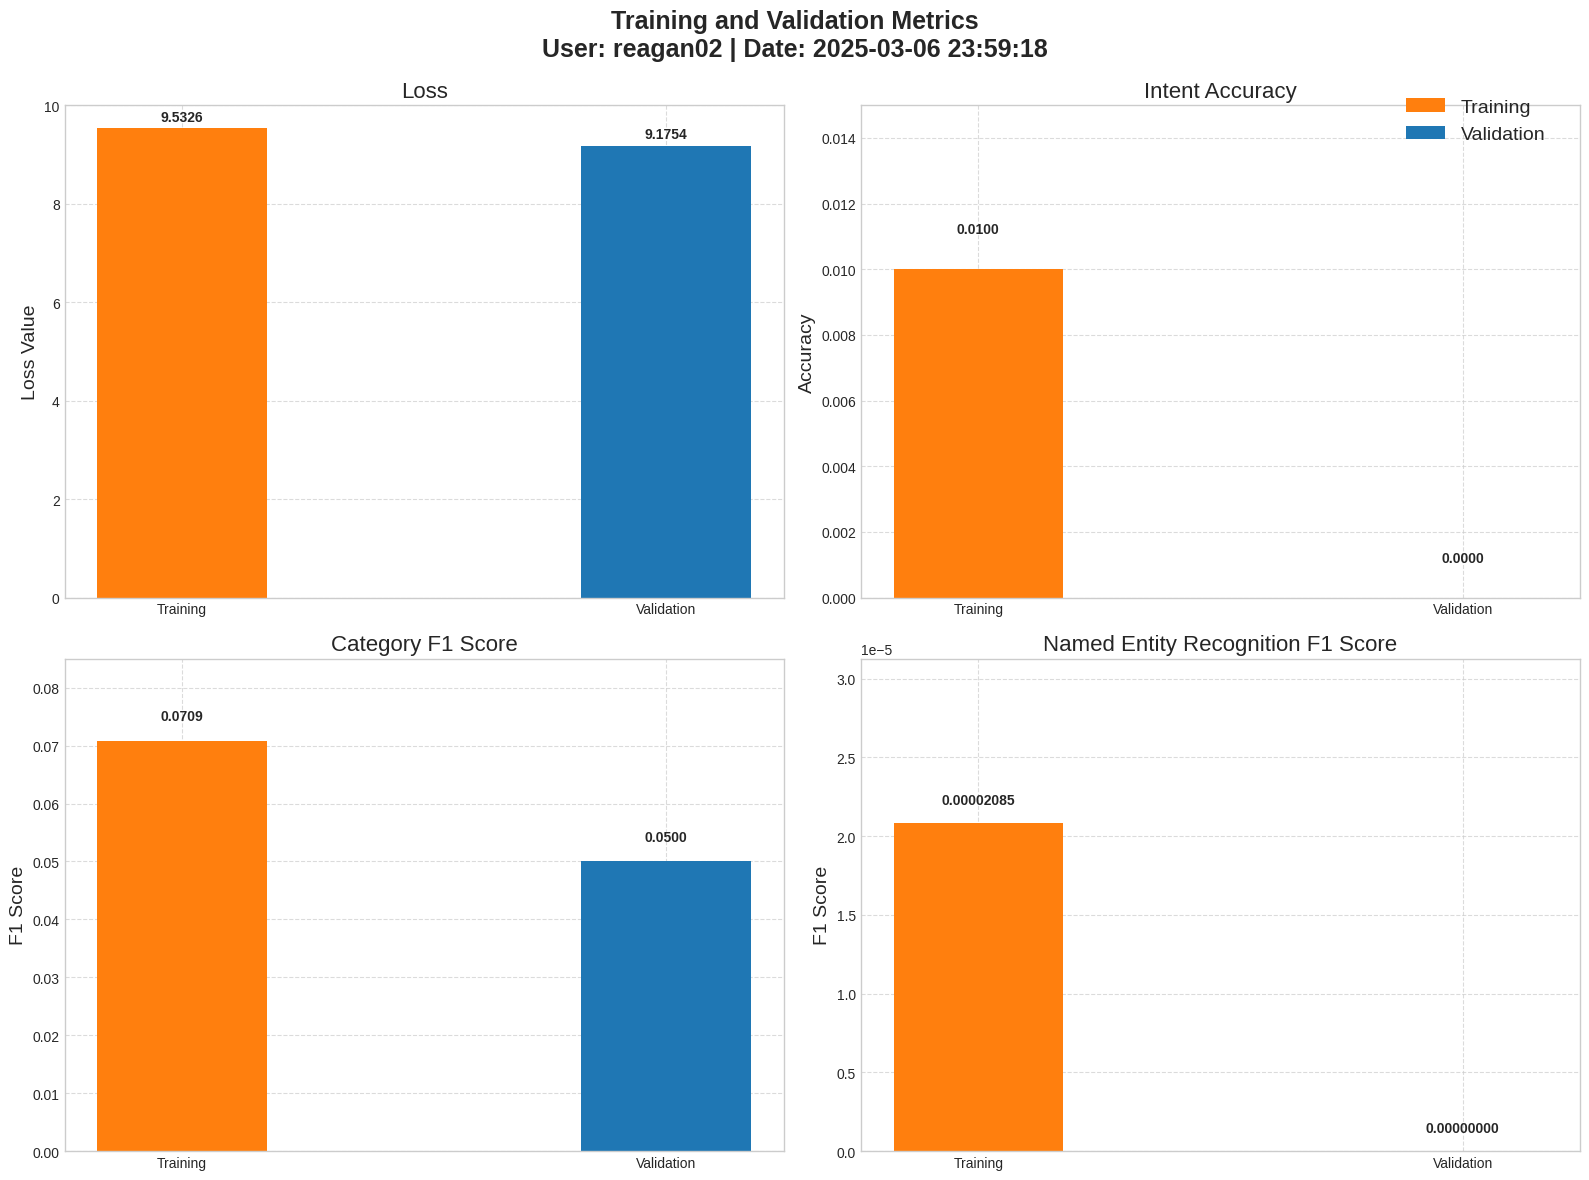

,Metric,Training,Validation
0,Loss,9.532568,9.175385
1,Intent Accuracy,0.010000,0.000000
2,Category F1,0.070858,0.050000
3,NER F1,0.000021,0.000000


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
%matplotlib inline

# Set plot style to match Jupyter Notebook aesthetics
plt.style.use('seaborn-v0_8-whitegrid')

# Current date and user information
current_date = "2025-03-06 23:59:18"
current_user = "reagan02"

# Data from the provided JSON
metrics_data = {
    "train_loss": [9.532567977905273],
    "val_loss": [9.175384998321533],
    "train_intent_acc": [0.01],
    "val_intent_acc": [0.0],
    "train_category_f1": [0.0708575112830432],
    "val_category_f1": [0.05],
    "train_ner_f1": [2.0849622100599424e-05],
    "val_ner_f1": [0.0]
}

# Convert data to DataFrame for easier handling
metrics_df = pd.DataFrame(metrics_data)

# Create figure with 4 subplots for each metric comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Training and Validation Metrics\nUser: {current_user} | Date: {current_date}',
             fontsize=18, fontweight='bold', y=0.98)

# Customize colors and styles
train_color = '#FF7F0E'  # Orange
val_color = '#1F77B4'    # Blue
bar_width = 0.35
index = np.array([0, 1])

# 1. Plot Loss - Top Left
axes[0, 0].bar(0, metrics_df['train_loss'][0], bar_width, color=train_color, label='Training')
axes[0, 0].bar(1, metrics_df['val_loss'][0], bar_width, color=val_color, label='Validation')
axes[0, 0].set_title('Loss', fontsize=16)
axes[0, 0].set_xticks(index)
axes[0, 0].set_xticklabels(['Training', 'Validation'])
axes[0, 0].text(0, metrics_df['train_loss'][0] + 0.1, f"{metrics_df['train_loss'][0]:.4f}",
                ha='center', va='bottom', fontweight='bold')
axes[0, 0].text(1, metrics_df['val_loss'][0] + 0.1, f"{metrics_df['val_loss'][0]:.4f}",
                ha='center', va='bottom', fontweight='bold')
axes[0, 0].set_ylabel('Loss Value', fontsize=14)
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# 2. Plot Intent Accuracy - Top Right
axes[0, 1].bar(0, metrics_df['train_intent_acc'][0], bar_width, color=train_color, label='Training')
axes[0, 1].bar(1, metrics_df['val_intent_acc'][0], bar_width, color=val_color, label='Validation')
axes[0, 1].set_title('Intent Accuracy', fontsize=16)
axes[0, 1].set_xticks(index)
axes[0, 1].set_xticklabels(['Training', 'Validation'])
axes[0, 1].text(0, metrics_df['train_intent_acc'][0] + 0.001, f"{metrics_df['train_intent_acc'][0]:.4f}",
                ha='center', va='bottom', fontweight='bold')
axes[0, 1].text(1, metrics_df['val_intent_acc'][0] + 0.001, f"{metrics_df['val_intent_acc'][0]:.4f}",
                ha='center', va='bottom', fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontsize=14)
axes[0, 1].set_ylim(0, max(metrics_df['train_intent_acc'][0], metrics_df['val_intent_acc'][0]) * 1.5 or 0.02)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# 3. Plot Category F1 - Bottom Left
axes[1, 0].bar(0, metrics_df['train_category_f1'][0], bar_width, color=train_color, label='Training')
axes[1, 0].bar(1, metrics_df['val_category_f1'][0], bar_width, color=val_color, label='Validation')
axes[1, 0].set_title('Category F1 Score', fontsize=16)
axes[1, 0].set_xticks(index)
axes[1, 0].set_xticklabels(['Training', 'Validation'])
axes[1, 0].text(0, metrics_df['train_category_f1'][0] + 0.003, f"{metrics_df['train_category_f1'][0]:.4f}",
                ha='center', va='bottom', fontweight='bold')
axes[1, 0].text(1, metrics_df['val_category_f1'][0] + 0.003, f"{metrics_df['val_category_f1'][0]:.4f}",
                ha='center', va='bottom', fontweight='bold')
axes[1, 0].set_ylabel('F1 Score', fontsize=14)
axes[1, 0].set_ylim(0, max(metrics_df['train_category_f1'][0], metrics_df['val_category_f1'][0]) * 1.2)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# 4. Plot NER F1 - Bottom Right
axes[1, 1].bar(0, metrics_df['train_ner_f1'][0], bar_width, color=train_color, label='Training')
axes[1, 1].bar(1, metrics_df['val_ner_f1'][0], bar_width, color=val_color, label='Validation')
axes[1, 1].set_title('Named Entity Recognition F1 Score', fontsize=16)
axes[1, 1].set_xticks(index)
axes[1, 1].set_xticklabels(['Training', 'Validation'])
axes[1, 1].text(0, metrics_df['train_ner_f1'][0] + 0.000001, f"{metrics_df['train_ner_f1'][0]:.8f}",
                ha='center', va='bottom', fontweight='bold')
axes[1, 1].text(1, metrics_df['val_ner_f1'][0] + 0.000001, f"{metrics_df['val_ner_f1'][0]:.8f}",
                ha='center', va='bottom', fontweight='bold')
axes[1, 1].set_ylabel('F1 Score', fontsize=14)
# Setting ylim to better visualize the very small NER F1 values
max_ner = max(metrics_df['train_ner_f1'][0], metrics_df['val_ner_f1'][0])
axes[1, 1].set_ylim(0, max_ner * 1.5 or 0.00003)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

# Add a legend to the entire figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.92), fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.90)

# Show the plot
plt.show()

# Print a summary table of the metrics
print("Summary of Model Metrics:")
summary_data = {
    'Metric': ['Loss', 'Intent Accuracy', 'Category F1', 'NER F1'],
    'Training': [metrics_df['train_loss'][0], metrics_df['train_intent_acc'][0],
                metrics_df['train_category_f1'][0], metrics_df['train_ner_f1'][0]],
    'Validation': [metrics_df['val_loss'][0], metrics_df['val_intent_acc'][0],
                  metrics_df['val_category_f1'][0], metrics_df['val_ner_f1'][0]]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df.style.format({
    'Training': '{:.6f}',
    'Validation': '{:.6f}'
}).set_caption(f"Model Performance - {current_date}"))

Table

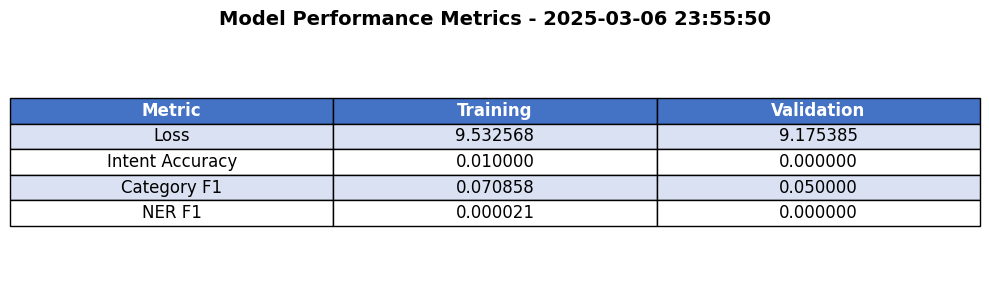

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the provided JSON
metrics = {
    "train_loss": [9.532567977905273],
    "val_loss": [9.175384998321533],
    "train_intent_acc": [0.01],
    "val_intent_acc": [0.0],
    "train_category_f1": [0.0708575112830432],
    "val_category_f1": [0.05],
    "train_ner_f1": [2.0849622100599424e-05],
    "val_ner_f1": [0.0]
}

# Extract values from lists to simplify the data
simplified_metrics = {k: v[0] for k, v in metrics.items()}

# Organize data for the table
data = {
    'Metric': ['Loss', 'Intent Accuracy', 'Category F1', 'NER F1'],
    'Training': [simplified_metrics['train_loss'],
                simplified_metrics['train_intent_acc'],
                simplified_metrics['train_category_f1'],
                simplified_metrics['train_ner_f1']],
    'Validation': [simplified_metrics['val_loss'],
                  simplified_metrics['val_intent_acc'],
                  simplified_metrics['val_category_f1'],
                  simplified_metrics['val_ner_f1']]
}

# Create DataFrame
df = pd.DataFrame(data)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')
ax.axis('tight')

# Create table
table = ax.table(
    cellText=[[f"{df.iloc[i, j]:.6f}" if j > 0 else df.iloc[i, j]
               for j in range(df.shape[1])]
              for i in range(df.shape[0])],
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Style header row
for i in range(len(df.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white', fontweight='bold')

# Alternating row colors
for i in range(1, len(df) + 1):
    if i % 2 == 1:
        for j in range(len(df.columns)):
            table[(i, j)].set_facecolor('#D9E1F2')

# Add title with timestamp
plt.suptitle(f'Model Performance Metrics - {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}',
             fontsize=14, fontweight='bold', y=0.95)

plt.tight_layout()
plt.savefig('training_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()

# Inference

In [15]:
# import torch
# from transformers import GPT2TokenizerFast
# import torch.nn.functional as F
# import json

# def run_inference(model_path: str, tokenizer_path: str, label_encoders_path: str, input_text: str, max_length: int = 128):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # Load the full model
#     model = torch.load(model_path, map_location=device, weights_only=False)
#     model.eval()

#     # Load tokenizer
#     tokenizer = GPT2TokenizerFast.from_pretrained(tokenizer_path)

#     # Load label encoders
#     with open(label_encoders_path, "r", encoding="utf-8") as f:
#         label_encoders = json.load(f)
#     intent_decoder = {v: k for k, v in label_encoders["intent_encoder"].items()}
#     category_decoder = {v: k for k, v in label_encoders["category_encoder"].items()}
#     ner_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}

#     # Preprocess input with offset mapping
#     inputs = tokenizer(
#         input_text,
#         return_tensors="pt",
#         max_length=max_length,
#         padding="max_length",
#         truncation=True,
#         return_offsets_mapping=True
#     )
#     inputs = {k: v.to(device) for k, v in inputs.items() if k != "offset_mapping"}
#     offset_mapping = inputs.get("offset_mapping", tokenizer(
#         input_text,
#         return_tensors="pt",
#         max_length=max_length,
#         padding="max_length",
#         truncation=True,
#         return_offsets_mapping=True
#     )["offset_mapping"])[0].cpu().tolist()

#     # Run inference
#     with torch.no_grad():
#         outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

#         # Intent prediction
#         intent_logits = outputs["intent_logits"]
#         intent_probs = F.softmax(intent_logits, dim=-1)[0]
#         intent_pred_idx = torch.argmax(intent_probs).item()
#         intent_confidence = intent_probs[intent_pred_idx].item()
#         intent_label = intent_decoder[intent_pred_idx]

#         # Category prediction
#         category_logits = outputs["category_logits"]
#         category_probs = F.softmax(category_logits, dim=-1)[0]
#         category_pred_idx = torch.argmax(category_probs).item()
#         category_confidence = category_probs[category_pred_idx].item()
#         category_label = category_decoder[category_pred_idx]

#         # NER prediction
#         ner_logits = outputs["ner_logits"][0]
#         ner_probs = F.softmax(ner_logits, dim=-1)
#         ner_pred_idxs = torch.argmax(ner_probs, dim=-1).tolist()
#         ner_confidences = torch.max(ner_probs, dim=-1).values.tolist()
#         ner_labels = [ner_decoder[idx] for idx in ner_pred_idxs]

#         seq_len = inputs["attention_mask"][0].sum().item()
#         ner_labels = ner_labels[:seq_len]
#         ner_confidences = ner_confidences[:seq_len]
#         offset_mapping = offset_mapping[:seq_len]

#     # Detect entity spans
#     entities = []
#     current_entity = None
#     entity_start = None
#     entity_confidences = []
#     entity_type = None

#     for i, (label, conf, (start, end)) in enumerate(zip(ner_labels, ner_confidences, offset_mapping)):
#         if label.startswith("B-"):
#             # If we were tracking an entity, save it before starting a new one
#             if current_entity is not None:
#                 entity_text = input_text[entity_start:offset_mapping[i-1][1]]
#                 entities.append({
#                     "entity": entity_text.strip(),
#                     "label": entity_type,  # Use entity_type as the label
#                     "confidence": sum(entity_confidences) / len(entity_confidences)
#                 })

#             # Start a new entity
#             current_entity = label[2:]
#             entity_type = label[2:]  # Save the entity type (e.g., "account_type")
#             entity_start = start
#             entity_confidences = [conf]

#         elif label.startswith("I-") and current_entity == label[2:]:
#             # Continue the current entity
#             entity_confidences.append(conf)

#         elif label == "O" and current_entity is not None:
#             # End of an entity
#             entity_text = input_text[entity_start:offset_mapping[i-1][1]]
#             entities.append({
#                 "entity": entity_text.strip(),
#                 "label": entity_type,  # Use entity_type as the label
#                 "confidence": sum(entity_confidences) / len(entity_confidences)
#             })
#             current_entity = None
#             entity_confidences = []
#             entity_type = None

#     # Check if there's an unfinished entity at the end of the sequence
#     if current_entity is not None:
#         entity_text = input_text[entity_start:offset_mapping[-1][1]]
#         entities.append({
#             "entity": entity_text.strip(),
#             "label": entity_type,  # Use entity_type as the label
#             "confidence": sum(entity_confidences) / len(entity_confidences)
#         })

#     # Compile results
#     results = {
#         "intent": {"label": intent_label, "confidence": intent_confidence},
#         "category": {"label": category_label, "confidence": category_confidence},
#         "ner": entities
#     }

#     return results

# # Load necessary components
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# output_dir = "/content/drive/MyDrive/thesis/Baseline_freeze_v1"
# model_path = os.path.join(output_dir, "baseline_model.pth")

# # Load saved label encoders
# with open(os.path.join(output_dir, "label_encoders.json"), 'r') as f:
#     label_encoders = json.load(f)
# print("Loaded label encoders from label_encoders.json")


# # Example usage
# input_text = "problems with retail account deletions"
# results = run_inference(
#     model_path=model_path,
#     tokenizer_path=gpt2_tokenizer,
#     label_encoders_path=label_encoders,
#     input_text=input_text
# )

# print("Inference Results:")
# print(f"Intent: {results['intent']['label']} (Confidence: {results['intent']['confidence']:.4f})")
# print(f"Category: {results['category']['label']} (Confidence: {results['category']['confidence']:.4f})")
# print("NER:")
# for entity in results['ner']:
#     print(f"  Entity: {entity['entity']} | Label: {entity['label']} | Confidence: {entity['confidence']:.4f}")

Loaded label encoders from label_encoders.json


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [20]:
import torch
import json
import os
from transformers import GPT2TokenizerFast

def inference_baseline(model, text: str, tokenizer, label_encoders, max_length: int, device):
    """Run inference with the BaselineGPT2MultiTask model with confidence scores as decimals"""
    model.eval()
    print(f"Inference on text: {text[:50]}...")

    # Tokenize input
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    inputs = {
        "input_ids": encoding["input_ids"].to(device),
        "attention_mask": encoding["attention_mask"].to(device)
    }

    # Run model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get softmax probabilities for confidence scores
    intent_logits = outputs["intent_logits"]
    category_logits = outputs["category_logits"]
    ner_logits = outputs["ner_logits"]

    # Apply softmax to get probabilities
    intent_probs = torch.nn.functional.softmax(intent_logits, dim=-1)[0]
    category_probs = torch.nn.functional.softmax(category_logits, dim=-1)[0]
    ner_probs = torch.nn.functional.softmax(ner_logits, dim=-1)

    # Get top predictions and their confidences
    intent_pred = torch.argmax(intent_probs).cpu().item()
    intent_confidence = intent_probs[intent_pred].cpu().item()  # As decimal (0.0-1.0)

    category_pred = torch.argmax(category_probs).cpu().item()
    category_confidence = category_probs[category_pred].cpu().item()  # As decimal (0.0-1.0)

    ner_preds = torch.argmax(ner_probs, dim=-1).cpu().numpy()[0]
    ner_confidences = torch.max(ner_probs, dim=-1)[0][0].cpu().numpy()  # Get max probability for each token

    # Map to labels
    intent_decoder = {v: k for k, v in label_encoders["intent_encoder"].items()}
    category_decoder = {v: k for k, v in label_encoders["category_encoder"].items()}
    ner_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}

    intent_label = intent_decoder[intent_pred]
    category_label = category_decoder[category_pred]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist())
    seq_len = int(inputs["attention_mask"][0].sum().item())
    ner_labels = [ner_decoder[pred] for pred in ner_preds[:seq_len]]

    # Extract entities from NER labels with confidence
    entities = []
    current_entity = None
    entity_tokens = []
    entity_confidences = []
    entity_type = None

    for i, (token, label, confidence) in enumerate(zip(tokens[:seq_len], ner_labels, ner_confidences[:seq_len])):
        if label.startswith("B-"):
            # If we were tracking an entity, save it before starting a new one
            if current_entity is not None:
                entity_text = tokenizer.convert_tokens_to_string(entity_tokens).strip()
                if entity_text:
                    # Calculate average confidence for the entity (as decimal)
                    avg_confidence = sum(entity_confidences) / len(entity_confidences)
                    entities.append({
                        "entity": entity_text,
                        "label": entity_type,
                        "confidence": avg_confidence
                    })

            # Start a new entity
            current_entity = label[2:]
            entity_type = label[2:]
            entity_tokens = [token]
            entity_confidences = [confidence]

        elif label.startswith("I-") and current_entity == label[2:]:
            # Continue current entity
            entity_tokens.append(token)
            entity_confidences.append(confidence)

        elif current_entity is not None:
            # End of an entity
            entity_text = tokenizer.convert_tokens_to_string(entity_tokens).strip()
            if entity_text:
                # Calculate average confidence for the entity (as decimal)
                avg_confidence = sum(entity_confidences) / len(entity_confidences)
                entities.append({
                    "entity": entity_text,
                    "label": entity_type,
                    "confidence": avg_confidence
                })
            current_entity = None
            entity_tokens = []
            entity_confidences = []
            entity_type = None

    # Check for unfinished entity
    if current_entity is not None:
        entity_text = tokenizer.convert_tokens_to_string(entity_tokens).strip()
        if entity_text:
            # Calculate average confidence for the entity (as decimal)
            avg_confidence = sum(entity_confidences) / len(entity_confidences)
            entities.append({
                "entity": entity_text,
                "label": entity_type,
                "confidence": avg_confidence
            })

    # Print results with confidence scores (show as percentages for readability)
    print(f"Predicted Intent: {intent_label} (Confidence: {intent_confidence:.4f})")
    print(f"Predicted Category: {category_label} (Confidence: {category_confidence:.4f})")
    print("NER Predictions:")
    for token, ner_label, conf in zip(tokens[:seq_len], ner_labels, ner_confidences[:seq_len]):
        print(f"{token:<15} | {ner_label:<20} | Confidence: {conf:.4f}")

    print("\nExtracted Entities:")
    for entity in entities:
        print(f"  Entity: {entity['entity']} | Label: {entity['label']} | Confidence: {entity['confidence']:.4f}")

    return {
        "intent": {"label": intent_label, "confidence": intent_confidence},
        "category": {"label": category_label, "confidence": category_confidence},
        "ner": entities
    }
# Load model and run inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = "/content/drive/MyDrive/thesis/Baseline_freeze_v1"
model_path = os.path.join(output_dir, "baseline_model.pth")

# Load label encoders
with open(os.path.join(output_dir, "label_encoders.json"), 'r') as f:
    label_encoders = json.load(f)

# Load tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Load hyperparameters
with open(os.path.join(output_dir, "hyperparameters.json"), 'r') as f:
    hyperparameters = json.load(f)

# Load your model (implementation depends on your setup)
# model = ... (load your model)

# Example text
example_text = "how can i cancel ord-21231"
results = inference_baseline(model, example_text, tokenizer, label_encoders,
                           max_length=hyperparameters["max_length"], device=device)

Inference on text: how can i cancel ord-21231...
Predicted Intent: cancel_order (Confidence: 0.3789)
Predicted Category: order (Confidence: 0.8452)
NER Predictions:
how             | O                    | Confidence: 0.7020
Ġcan            | O                    | Confidence: 0.9372
Ġi              | O                    | Confidence: 0.9509
Ġcancel         | O                    | Confidence: 0.9337
Ġord            | B-order_number       | Confidence: 0.9853
-               | I-order_number       | Confidence: 0.9302
212             | I-order_number       | Confidence: 0.9524
31              | I-order_number       | Confidence: 0.9698

Extracted Entities:
  Entity: ord-21231 | Label: order_number | Confidence: 0.9594
